# **ZDT1** Problem

In [1]:
%pip install pymoo --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00


In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from pymoo.indicators.hv import Hypervolume
import numpy as np
import random


C:\Users\paula\AppData\Local\Temp\ipykernel_40280\1118491624.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")


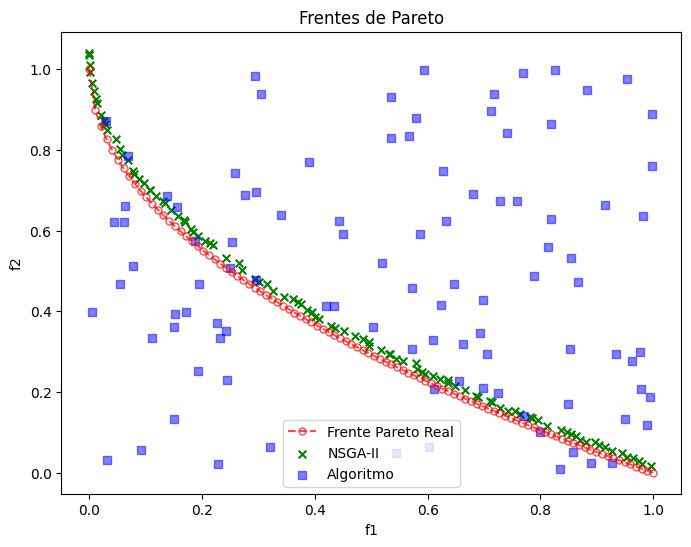

In [15]:
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)

# Genera un frente de pareto aleatorio
def random_pareto_front(num_points=100):
    f1 = np.random.uniform(0, 1, num_points)
    f2 = np.random.uniform(0, 1, num_points)
    return np.column_stack([f1, f2])

# Función para graficar los frentes de Pareto
def plot_pareto_example(problem, nsga2_pareto, alg_pareto):

    nsga2_f1, nsga2_f2 = nsga2_pareto.F[:, 0], nsga2_pareto.F[:, 1]

    plt.figure(figsize=(8, 6))

    # Frente de Pareto real de ZDT1 (rojo, puntos huecos)
    plt.plot(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1],
             color="red", label="Frente Pareto Real", linestyle="--", marker='o', markersize=5, alpha=0.7, markerfacecolor='none')

    # Frente de Pareto de NSGA-II (verde, puntos sólidos)
    plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")

    # Frente de Pareto del algoritmo implementado (azul, puntos con opacidad)
    plt.scatter(alg_pareto[:, 0], alg_pareto[:, 1], color="blue", label="Algoritmo", alpha=0.5, marker='s')

    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Frentes de Pareto")
    plt.legend()
    plt.show()

alg_pareto = random_pareto_front()
plot_pareto_example(problem, nsga2_pareto, alg_pareto)

---

## **Algoritmo Diferencial**

La propuesta es un algoritmo evolutivo diferencial adaptado a problemas de optimización multiobjetivo, basado en las ideas del artículo:
ZDT, D. T. (2015). Performance analysis of variants of differential evolution on multi-objective optimization problems. Indian Journal of Science and Technology, 8(17), 65727.

Los **algoritmos evolutivos diferenciales** se caracterizan por seleccionar, para cada individuo de la población, tres individuos aleatorios diferentes de forma equiprobable. Estos individuos se combinan gen a gen mediante una fórmula lineal para generar un hijo. Posteriormente, se realiza un proceso de crossover con el individuo original, donde se decide conservar el gen del hijo generado o el gen del padre.

En este caso, el algoritmo está adaptado para manejar problemas multiobjetivo utilizando frentes de Pareto. La selección entre el hijo y el padre se realiza evaluando la dominancia:

- Si el hijo domina al padre, este último es reemplazado.
- En caso contrario, el padre permanece en la población.

Se incorpora una caché, una unidad de almacenamiento temporal para los valores de fitness de los individuos. Gracias a esta caché, es posible gestionar eficientemente las 10,000 evaluaciones de fitness, asegurando que cada evaluación sea única para cada individuo.


La configuración de los parámetros es la siguiente:
- Terminación por el número de evaluaciones: 10,000 evaluaciones de la función multi-objetivo.
- Factor de escala (F): 0.2. es un parámetro que controla la magnitud de la diferencia entre los genes.
- Probabilidad de cruce (CR): Esto significa que existe un 40% de probabilidad de conservar el gen del hijo generado en el nuevo individuo, mientras que en el 60% restante se mantiene el gen del padre.


Se realizan 3 pruebas:

1. Prueba individual del algoritmo: un único experimento
2. Prueba experimentos múltiples: 10 experimentos
3. Prueba con F dinámico: Se configuran 7 tipos de F dinámicos, los cuales se actualizan a medida que avanza el algoritmo evolutivo. Cada tipo de F se evalúa mediante 10 experimentos. La elección del mejor valor de F dinámico se basa en una métrica compuesta que combina las tres métricas: hipervolumen, dispersión y espaciado.

In [16]:
def calculate_metrics(front, ref_point):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). """
    metricHV = Hypervolume(ref_point)

    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))
    return hv, spr, spa


def fitness_zdt1(individual: np.ndarray) -> np.ndarray:
    f1 = individual[0]
    g = 1 + 9*np.sum(individual[1:]) / (len(individual)-1)
    f2 = 1 - np.sqrt(f1 / g )

    return np.array([f1, f2])

In [17]:
def dominance_rank(individual, population):
    """ Calcula el rango de dominancia de Pareto de un individuo en la población.
        - Menor rango significa que está en un frente de Pareto más alto (más óptimo) """
    dominated_count = 0
    for other in population:
        if dominates(individual, other):
            dominated_count += 1

    return dominated_count


def dominates(individual_1, individual_2):
    """
    Determina si el individuo 1 domina al individuo 2.
    Se dice que un individuo A domina a B si:
    - A es mejor o igual que B en todos los objetivos
    - A es estrictamente mejor que B en al menos un objetivo
    """
    f1_1, f2_1 = fitness_zdt1(individual_1)
    f1_2, f2_2 = fitness_zdt1(individual_2)

    return (f1_1 <= f1_2 and f2_1 <= f2_2) and (f1_1 < f1_2 or f2_1 < f2_2)


def get_pareto_front(population, fitness_function):
    pareto_front = []
    for ind in population:
        is_dominated = False
        for other in population:
            if dominates(other, ind):  # Si algún otro individuo domina a este
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(ind)
    return pareto_front


def sort_pop(pop, fitness):
    """ Ordena la población según su rango de dominancia de Pareto (de menor a mayor rango) """

    pop_with_rank = [(indiv, dominance_rank(indiv, pop)) for indiv in pop]
    sorted_pop = sorted(pop_with_rank, key=lambda x: x[1])

    return [indiv for indiv, _ in sorted_pop], [fitness(indiv) for indiv, _ in sorted_pop]


# 1. Inicialización de la población
def create_population(N, problem, num_variables):
    lower_bounds, upper_bounds = problem.bounds()
    return np.random.uniform(lower_bounds, upper_bounds, (100, problem.n_var))

In [18]:
def calculate_F(F_initial, F_mode, t, T):
    """ Calcula el valor de F dinámicamente según el modo seleccionado. """
    if F_mode == 1:
        return F_initial * (1 - t / T)
    elif F_mode == 2:
        return F_initial * np.exp(-t / T)
    elif F_mode == 3:
        return F_initial * np.sin(t / T)
    elif F_mode == 4:
        return F_initial * np.cos(t / T)
    elif F_mode == 5:
        return F_initial * np.tan(t / T)
    elif F_mode == 6:
        return F_initial * np.log(t / T) if t > 0 else F_initial  # Evitar log(0)
    elif F_mode == 7:
        return F_initial * (np.sin(t / T) + np.cos(t / T))
    else:  # Modo 0 o cualquier valor no reconocido
        return F_initial

In [19]:
def differential_evolution_step(pop, fitness, fitness_cache, F_initial, CR, F_mode, t=0, T=10000):
    """
    Un paso del algoritmo diferencial DE/rand/1/bin.
    Utiliza una caché para evitar recalcular fitness ya conocidos.
    """
    NP = len(pop)
    new_pop = []

    F = calculate_F(F_initial, F_mode, t, T)

    for i in range(NP):
        # se eligen tres individuos aleatorios diferentes
        Xj1, Xj2, Xj3 = random.sample([ind for ind in pop if not np.array_equal(ind, pop[i])], 3)

        # se crea un hijo usando la fórmula DE/rand/1/bin
        child = [Xj1[k] + F * (Xj2[k] - Xj3[k]) for k in range(len(Xj1))]
        child = np.clip(child, 0, 1)  # Importante: limitacion de los genes entre [0, 1]

        # cruce con el individuo original para formar el hijo definitivo
        for j in range(len(child)):
            if random.random() > CR:
                child[j] = pop[i][j]

        child = np.clip(child, 0, 1)

        # calcula el fitness del hijo si no está en la caché
        child_tuple = tuple(child)
        if child_tuple not in fitness_cache:
            fitness_cache[child_tuple] = fitness(child)

        # calcula el fitness del padre (ya debe estar en la caché)
        parent_tuple = tuple(pop[i])
        if parent_tuple not in fitness_cache:
            fitness_cache[parent_tuple] = fitness(pop[i])

        # sustituye al padre si el hijo lo domina
        fitness_child = fitness_cache[child_tuple]
        fitness_parent = fitness_cache[parent_tuple]

        if dominates(child, pop[i]):
            pop[i] = child

        new_pop.append(child)

    return pop, fitness_cache

In [20]:
def evolve_with_DE(pop, fitness, F, CR, neval, trace, F_mode):
    """
    Evoluciona la población usando el algoritmo diferencial DE/rand/1/bin.
    Usa una cache para evitar recalcular fitness.
    """
    evals = 0  # Contador de evaluaciones
    fitness_cache = {}  # Caché para almacenar fitness calculados

    # cache inicializada con los fitness de la población inicial
    for ind in pop:
        ind_tuple = tuple(ind)
        if ind_tuple not in fitness_cache:
            fitness_cache[ind_tuple] = fitness(ind)
            evals += 1  # Se cuenta cada evaluación inicial

    t = 0
    while evals < neval:
        # Un paso del algoritmo diferencial
        pop, fitness_cache = differential_evolution_step(pop, fitness, fitness_cache, F, CR, F_mode, t, neval)

        # Se actualizan las evaluaciones solo por nuevos fitness calculados
        new_eval_fitness = len(fitness_cache) - evals
        evals += new_eval_fitness

        t += 1

        # Si alcanzamos el límite de evaluaciones --> finish
        if evals >= neval:
            break

    return pop, evals

## Algoritmo IBEA

Implementación obtenida de: Zitzler E, Künzli S. Indicator-based selection in multiobjective search[C]//International Conference on Parallel Problem Solving from Nature. Berlin, Heidelberg: Springer Berlin Heidelberg, 2004: 832-842. [Link a github](https://github.com/Xavier-MaYiMing/IBEA/tree/main?tab=readme-ov-file#ibea-indicator-based-evolutionary-algorithm)

In [60]:
def cal_obj(pop, nobj):
    f1 = pop[:, 0]  # f1 = x1
    g = 1 + 9 * np.sum(pop[:, 1:], axis=1) / (pop.shape[1] - 1)
    h = 1 - np.sqrt(f1 / g)  # h(f1, g) = 1 - sqrt(f1 / g)

    return np.column_stack([f1, h])  # Solo dos objetivos

def cal_fitness(objs, kappa):
    npop = objs.shape[0]
    objs = (objs - np.min(objs, axis=0)) / (np.max(objs, axis=0) - np.min(objs, axis=0))
    I = np.zeros((npop, npop))
    for i in range(npop):
        for j in range(npop):
            I[i, j] = np.max(objs[i] - objs[j])
    C = np.max(np.abs(I), axis=0)
    fitness = np.sum(-np.exp(-I / np.tile(C, (npop, 1)) / kappa), axis=0) + 1
    return fitness, I, C


def selection(pop, objs, kappa, k=2):
    (npop, nvar) = pop.shape
    fitness = cal_fitness(objs, kappa)[0]
    nm = npop if npop % 2 == 0 else npop + 1
    mating_pool = np.zeros((nm, nvar))
    for i in range(nm):
        [ind1, ind2] = np.random.choice(npop, k, replace=False)
        if fitness[ind1] > fitness[ind2]:
            mating_pool[i] = pop[ind1]
        else:
            mating_pool[i] = pop[ind2]
    return mating_pool


def crossover(mating_pool, lb, ub, eta_c):
    (noff, nvar) = mating_pool.shape
    nm = int(noff / 2)
    parent1 = mating_pool[:nm]
    parent2 = mating_pool[nm:]
    beta = np.zeros((nm, nvar))
    mu = np.random.random((nm, nvar))
    flag1 = mu <= 0.5
    flag2 = ~flag1
    beta[flag1] = (2 * mu[flag1]) ** (1 / (eta_c + 1))
    beta[flag2] = (2 - 2 * mu[flag2]) ** (-1 / (eta_c + 1))
    beta = beta * (-1) ** np.random.randint(0, 2, (nm, nvar))
    beta[np.random.random((nm, nvar)) < 0.5] = 1
    beta[np.tile(np.random.random((nm, 1)) > 1, (1, nvar))] = 1
    offspring1 = (parent1 + parent2) / 2 + beta * (parent1 - parent2) / 2
    offspring2 = (parent1 + parent2) / 2 - beta * (parent1 - parent2) / 2
    offspring = np.concatenate((offspring1, offspring2), axis=0)
    offspring = np.min((offspring, np.tile(ub, (noff, 1))), axis=0)
    offspring = np.max((offspring, np.tile(lb, (noff, 1))), axis=0)
    return offspring


def mutation(pop, lb, ub, eta_m):
    (npop, nvar) = pop.shape
    lb = np.tile(lb, (npop, 1))
    ub = np.tile(ub, (npop, 1))
    site = np.random.random((npop, nvar)) < 1 / nvar
    mu = np.random.random((npop, nvar))
    delta1 = (pop - lb) / (ub - lb)
    delta2 = (ub - pop) / (ub - lb)
    temp = np.logical_and(site, mu <= 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * ((2 * mu[temp] + (1 - 2 * mu[temp]) * (1 - delta1[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1)
    temp = np.logical_and(site, mu > 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * (1 - (2 * (1 - mu[temp]) + 2 * (mu[temp] - 0.5) * (1 - delta2[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)))
    pop = np.min((pop, ub), axis=0)
    pop = np.max((pop, lb), axis=0)
    return pop


def environmental_selection(pop, objs, num, kappa):
    Next = np.arange(pop.shape[0])
    fitness, I, C = cal_fitness(objs, kappa)
    while Next.shape[0] > num:
        worst = np.argmin(fitness[Next])
        fitness += np.exp(-I[Next[worst]] / C[Next[worst]] / kappa)
        Next = np.delete(Next, worst)
    return pop[Next], objs[Next]


def dominates(obj1, obj2):
    sum_less = 0
    for i in range(len(obj1)):
        if obj1[i] > obj2[i]:
            return False
        elif obj1[i] != obj2[i]:
            sum_less += 1
    return sum_less > 0


def main(npop, max_evaluations, lb, ub, nobj=2, kappa=0.05, eta_c=20, eta_m=20):
    """
    Función principal
    """
    # Paso 1. Inicialización
    nvar = len(lb)  # La dimensión del espacio de decisiones
    pop = np.random.uniform(lb, ub, (npop, nvar))  # Población
    objs = cal_obj(pop, nobj)  # Cálculo de objetivos
    evaluations = npop

    # Paso 2. Bucle principal
    while evaluations < max_evaluations:
        # Si se alcanza el límite de evaluaciones, termina
        if evaluations >= max_evaluations:
            break

        # Paso 2.1. Selección de padres, cruce y mutación
        mating_pool = selection(pop, objs, kappa)
        off = crossover(mating_pool, lb, ub, eta_c)
        off = mutation(off, lb, ub, eta_m)
        off_objs = cal_obj(off, nobj)
        evaluations += off.shape[0]

        # Paso 2.2. Selección ambiental
        pop, objs = environmental_selection(np.concatenate((pop, off), axis=0), np.concatenate((objs, off_objs), axis=0), npop, kappa)

    # Paso 3. Ordenar los resultados y mostrar el frente de Pareto
    dom = np.full(npop, False)
    for i in range(npop - 1):
        for j in range(i, npop):
            if not dom[i] and dominates(objs[j], objs[i]):
                dom[i] = True
            if not dom[j] and dominates(objs[i], objs[j]):
                dom[j] = True

    pf = objs[~dom]
    return pf

### **Evaluación** Individual

In [25]:
# Función para graficar los frentes de Pareto
def plot_pareto(problem, nsga2_pareto, pop, pf):

    nsga2_f1, nsga2_f2 = nsga2_pareto.F[:, 0], nsga2_pareto.F[:, 1]
    plt.figure(figsize=(8, 6))

    # Frente de Pareto real de ZDT1 (rojo, puntos huecos)
    plt.plot(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1],
             color="red", label="Frente Pareto Real", linestyle="--", marker='o', markersize=5, alpha=0.7, markerfacecolor='none')

    # Frente de Pareto de NSGA-II (verde, puntos sólidos)
    plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x')

    # Frente de Pareto del algoritmo diferencial (azul, puntos con opacidad)
    f1, f2 = zip(*[fitness_zdt1(ind) for ind in pop])
    plt.scatter(f1, f2, color="blue", label="Algoritmo Diferencial", alpha=0.5, marker='s')
    
    # Frente de Pareto del algoritmo IBEA (naranja, puntos ^)
    plt.scatter(pf[:, 0], pf[:, 1], color="orange", label="Algoritmo IBEA", alpha=0.8, marker='^', s=40)

    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Frentes de Pareto")
    plt.legend()
    plt.show()


- Evaluaciones:  10000
- Tamaño del Frente de Pareto: 72

                Hipervolumen  Dispersión (SPR)  Espaciado (SPA)
Diferencial        0.632724          1.221131         0.011918
IBEA               0.661448          1.370213         0.012556
NSGA2 a Batir      0.637858          1.427959         0.011438


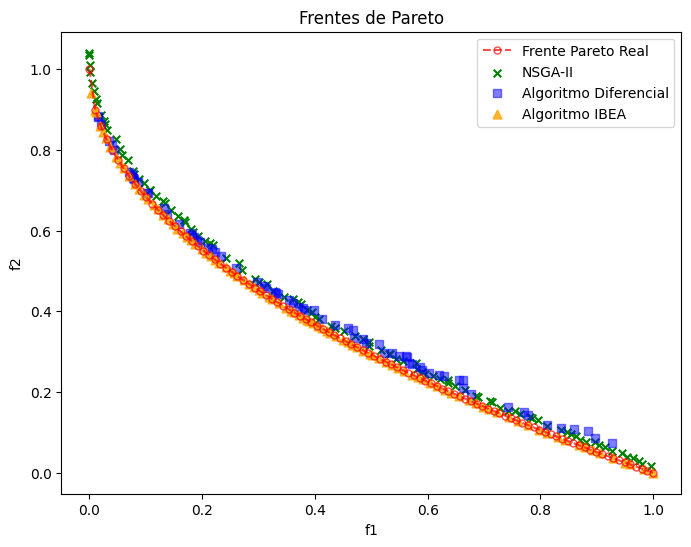

In [26]:
### Inicializar el problema ZDT1 y obtener pareto de NSGA2 para comparar ###
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
ref_point = [1, 1]
ref_point_ibea = [2.0, 2.0]

if nsga2_pareto is None: nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)

population = create_population(100, problem, 30)

###########################################
###### Llamada Algoritmo Diferencial ######
###########################################

result_population, evals = evolve_with_DE(population, fitness=fitness_zdt1, F=0.2, CR=0.4, neval=10000, trace=100, F_mode=0)

pareto_front_dif = get_pareto_front(result_population, fitness_zdt1)
pareto_objectives_dif = np.array([fitness_zdt1(ind) for ind in pareto_front_dif])

print("- Evaluaciones: ", evals)
print("- Tamaño del Frente de Pareto:", len(pareto_front_dif))

##########################################
####### Llamada Algoritmo IBEA ###########
##########################################
lb = np.array([0] * 7)
ub = np.array([1] * 7)
pf_ibea = main(npop=100, max_evaluations=10000, lb=lb, ub=ub, nobj=2)

####################
##### Métricas #####
####################
hv_dif, spr_dif, spa_dif = calculate_metrics(pareto_objectives_dif, ref_point)

hv_ibea, spr_ibea, spa_ibea = calculate_metrics(pf_ibea, ref_point)

hv_obj, spr_obj, spa_obj = calculate_metrics(nsga2_pareto.F, ref_point)

data = {'Hipervolumen': [hv_dif, hv_ibea, hv_obj], 'Dispersión (SPR)': [spr_dif, spr_ibea, spr_obj], 'Espaciado (SPA)': [spa_dif, spa_ibea, spa_obj]}
df = pd.DataFrame(data, index=['Diferencial', 'IBEA', 'NSGA2 a Batir'])
print(f"\n {df}")

####################
##### Graficas #####
####################
plot_pareto(problem, nsga2_pareto, pareto_front_dif, pf_ibea)

### Evaluación Múltiples Experimentos IBEA

In [48]:
termination = ('n_eval', 10000)
def multiple_experiments_ibea(problem, termination=termination, n_experiments=10, pop_size=100):
    
    hv_results = []
    spr_results = []
    spa_results = []
    results = []
    
    for i in range(n_experiments):
        
        # Optimización
        pf = main(npop=100, max_evaluations=10000, lb=lb, ub=ub, nobj=2)
        
        # Calcular métricas
        hv, spr, spa = calculate_metrics(pf, ref_point=ref_point)
        print(f"\nMétricas Experimento {i+1}: Hipervolumen (HV): {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")
        
        hv_results.append(hv)
        spr_results.append(spr)
        spa_results.append(spa)
        results.append(pf)

    
    # Media y varianza de las métricas 
    avg_hv = np.mean(hv_results)
    var_hv = np.var(hv_results)
    
    avg_spr = np.mean(spr_results)
    var_spr = np.var(spr_results)
    
    avg_spa = np.mean(spa_results)
    var_spa = np.var(spa_results)
    
    print(f"\nResultados Promediados y Variados tras {n_experiments} experimentos:")
    print(f"  Promedio de Hipervolumen (HV): {avg_hv:.5f} | Varianza: {var_hv:.5f}")
    print(f"  Promedio de Dispersión (SPR): {avg_spr:.5f} | Varianza: {var_spr:.5f}")
    print(f"  Promedio de Espaciado (SPA): {avg_spa:.5f} | Varianza: {var_spa:.5f}")
    
    return avg_hv, var_hv, avg_spr, var_spr, avg_spa, var_spa, results
def multiple_experiments(problem, algorithm_class, termination=termination, n_experiments=10, pop_size=100):
    
    hv_results = []
    spr_results = []
    spa_results = []
    results = []
    
    for i in range(n_experiments):
        algorithm = algorithm_class(pop_size=pop_size)
        
        # Optimización
        res = minimize(problem, algorithm, termination=termination, verbose=False)
        
        # Obtener el frente de Pareto
        pf = res.F  
        
        # Calcular métricas
        hv, spr, spa = calculate_metrics(pf, ref_point=ref_point)
        print(f"\nMétricas Experimento {i+1}: Hipervolumen (HV): {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")
        
        hv_results.append(hv)
        spr_results.append(spr)
        spa_results.append(spa)
        results.append(res)

    
    # Media y varianza de las métricas 
    avg_hv = np.mean(hv_results)
    var_hv = np.var(hv_results)
    
    avg_spr = np.mean(spr_results)
    var_spr = np.var(spr_results)
    
    avg_spa = np.mean(spa_results)
    var_spa = np.var(spa_results)
    
    print(f"\nResultados Promediados y Variados tras {n_experiments} experimentos:")
    print(f"  Promedio de Hipervolumen (HV): {avg_hv:.5f} | Varianza: {var_hv:.5f}")
    print(f"  Promedio de Dispersión (SPR): {avg_spr:.5f} | Varianza: {var_spr:.5f}")
    print(f"  Promedio de Espaciado (SPA): {avg_spa:.5f} | Varianza: {var_spa:.5f}")
    
    return avg_hv, var_hv, avg_spr, var_spr, avg_spa, var_spa, results

In [43]:
avg_hv_ibea, var_hv_ibea, avg_spr_ibea, var_spr_ibea, avg_spa_ibea, var_spa_ibea, results_ibea = multiple_experiments_ibea(problem, n_experiments=10)


Métricas Experimento 1: Hipervolumen (HV): 0.6617, Dispersión (SPR): 1.3743, Espaciado (SPA): 0.0123

Métricas Experimento 2: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3917, Espaciado (SPA): 0.0128

Métricas Experimento 3: Hipervolumen (HV): 0.6616, Dispersión (SPR): 1.3788, Espaciado (SPA): 0.0128

Métricas Experimento 4: Hipervolumen (HV): 0.6616, Dispersión (SPR): 1.3719, Espaciado (SPA): 0.0125

Métricas Experimento 5: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3944, Espaciado (SPA): 0.0130

Métricas Experimento 6: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3840, Espaciado (SPA): 0.0125

Métricas Experimento 7: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3857, Espaciado (SPA): 0.0118

Métricas Experimento 8: Hipervolumen (HV): 0.6616, Dispersión (SPR): 1.3841, Espaciado (SPA): 0.0127

Métricas Experimento 9: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3746, Espaciado (SPA): 0.0126

Métricas Experimento 10: Hipervolumen (HV): 0.6615, Dispersión (SPR): 1.3762, Esp

In [49]:
avg_hv_nsga2, var_hv_nsga2, avg_spr_nsga2, var_spr_nsga2, avg_spa_nsga2, var_spa_nsga2, results_nsga2 = multiple_experiments(problem, NSGA2, n_experiments=10)


Métricas Experimento 1: Hipervolumen (HV): 0.6342, Dispersión (SPR): 1.4369, Espaciado (SPA): 0.0121

Métricas Experimento 2: Hipervolumen (HV): 0.6338, Dispersión (SPR): 1.4229, Espaciado (SPA): 0.0112

Métricas Experimento 3: Hipervolumen (HV): 0.6317, Dispersión (SPR): 1.4339, Espaciado (SPA): 0.0118

Métricas Experimento 4: Hipervolumen (HV): 0.6440, Dispersión (SPR): 1.4115, Espaciado (SPA): 0.0115

Métricas Experimento 5: Hipervolumen (HV): 0.6412, Dispersión (SPR): 1.4247, Espaciado (SPA): 0.0113

Métricas Experimento 6: Hipervolumen (HV): 0.6446, Dispersión (SPR): 1.4105, Espaciado (SPA): 0.0118

Métricas Experimento 7: Hipervolumen (HV): 0.6427, Dispersión (SPR): 1.4066, Espaciado (SPA): 0.0113

Métricas Experimento 8: Hipervolumen (HV): 0.6363, Dispersión (SPR): 1.4282, Espaciado (SPA): 0.0123

Métricas Experimento 9: Hipervolumen (HV): 0.6347, Dispersión (SPR): 1.4345, Espaciado (SPA): 0.0120

Métricas Experimento 10: Hipervolumen (HV): 0.6367, Dispersión (SPR): 1.4257, Esp

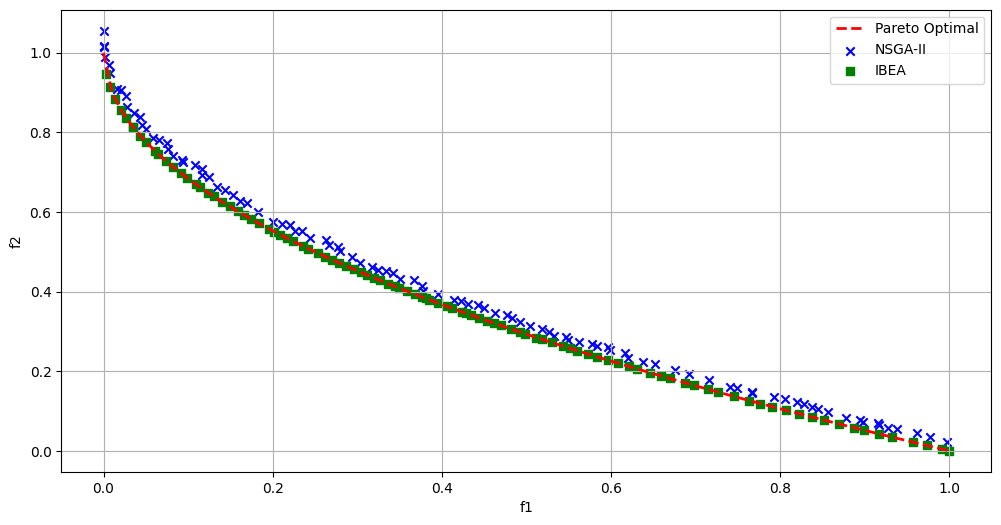

In [59]:
best_pf_nsga2 = results_nsga2[np.argmax(avg_hv_nsga2)].F
best_pf_ibea = results_ibea[np.argmax(avg_hv_ibea)]

plt.figure(figsize=(12, 6))

# frente de Pareto Optimo
pareto_optimal = problem.pareto_front()
hv_optimal, spr_optimal, spa_optimal = calculate_metrics(pareto_optimal, ref_point)
plt.plot(pareto_optimal[:, 0], pareto_optimal[:, 1], color='red', label="Pareto Optimal", linestyle='--', linewidth=2)

plt.scatter(best_pf_nsga2[:, 0], best_pf_nsga2[:, 1], label="NSGA-II", color='blue', marker='x')
plt.scatter(best_pf_ibea[:, 0], best_pf_ibea[:, 1], label="IBEA", color='green', marker='s')

plt.xlabel("f1")
plt.ylabel("f2")
plt.legend()
plt.grid(True)
plt.show()

### **Evaluación** Múltiples Experimentos Diferencial

In [25]:
'''
    Ejecuta múltiples experimentos dado un problema y un algoritmo de optimización multi-objetivo. Se le pasa el punto de referencia del hipervolumen,
    el número de experimentos y el número de generaciones. El criterio de selección del mejor frente de pareto se puede modificar. Por defecto, se hace según
    el hipervolumen.

    @return
        - best_individual_ frente_pareto [[distance1, time1], [distance2, time2], ...],
        - metrics_summary: resumen de metricas de los 10 experimentos
'''
def multiple_experiments_with_metrics(problem, fitness_function, ref_point, num_experiments=10,
                                      pop_size=100, F=0.2, CR=0.4, neval=10000, trace=100, F_mode=0):

    best_pareto = None
    best_pareto_objectives = None

    best_hypervolume = -float('inf')

    metrics_summary = []

    for i in range(num_experiments):

        population = create_population(pop_size, problem, 30)
        # Algoritmo Diferencial
        result_population, evals = evolve_with_DE(population, fitness=fitness_function, F=F, CR=CR, neval=neval, trace=trace, F_mode=0)

        pareto_front = get_pareto_front(result_population, fitness_zdt1)
        pareto_objectives = np.array([fitness_zdt1(ind) for ind in pareto_front])

        if pareto_front is None or len(pareto_front) == 0:
            continue

        # Métricas del pareto
        hv, spr, spa = calculate_metrics(pareto_objectives, ref_point=np.array([1.0, 1.0]))
        metrics_summary.append((hv, spr, spa))

        if F_mode == 0: print(f"Experimento {i+1} | Mode: {F_mode} | Evals: {evals}: Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Comparacion mediante el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            best_pareto = pareto_front
            best_pareto_objectives = pareto_objectives

    # Promedios y desviaciones estándar de las métricas
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print(f"\n--- Resumen de Métricas con F_mode: [{F_mode}] ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return best_pareto, best_pareto_objectives, metrics_summary

Experimento 1 | Evals: 10000: Hipervolumen: 0.6327, Dispersión (SPR): 1.3258, Espaciado (SPA): 0.0128
Experimento 2 | Evals: 10000: Hipervolumen: 0.6278, Dispersión (SPR): 1.3221, Espaciado (SPA): 0.0168
Experimento 3 | Evals: 10000: Hipervolumen: 0.6347, Dispersión (SPR): 1.3077, Espaciado (SPA): 0.0140
Experimento 4 | Evals: 10000: Hipervolumen: 0.6340, Dispersión (SPR): 1.2842, Espaciado (SPA): 0.0120
Experimento 5 | Evals: 10000: Hipervolumen: 0.6358, Dispersión (SPR): 1.3567, Espaciado (SPA): 0.0146
Experimento 6 | Evals: 10000: Hipervolumen: 0.6362, Dispersión (SPR): 1.2355, Espaciado (SPA): 0.0111
Experimento 7 | Evals: 10000: Hipervolumen: 0.6332, Dispersión (SPR): 1.3009, Espaciado (SPA): 0.0125
Experimento 8 | Evals: 10000: Hipervolumen: 0.6275, Dispersión (SPR): 1.3105, Espaciado (SPA): 0.0125
Experimento 9 | Evals: 10000: Hipervolumen: 0.6337, Dispersión (SPR): 1.3165, Espaciado (SPA): 0.0132
Experimento 10 | Evals: 10000: Hipervolumen: 0.6347, Dispersión (SPR): 1.3114, Esp

<ipython-input-11-e8807f9ecb42>:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")


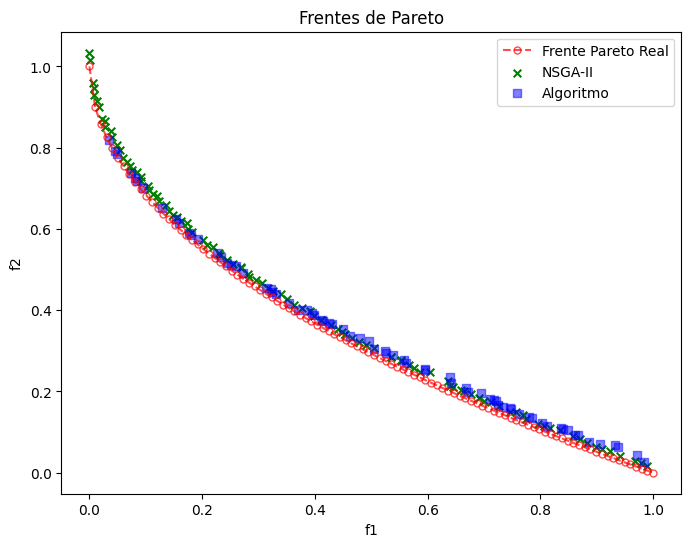

In [18]:
### Inicializar el problema ZDT1 y obtener pareto de NSGA2 para comparar ###
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
ref_point = [1, 1]

if nsga2_pareto is None: nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)

best_pareto, best_pareto_objetives, metrics_summary = multiple_experiments_with_metrics(problem, fitness_zdt1, ref_point, num_experiments=10, F_mode=0)

####################
### Métricas ###
####################
hv, spr, spa = calculate_metrics(best_pareto_objetives, ref_point)
hv_obj, spr_obj, spa_obj = calculate_metrics(nsga2_pareto.F, ref_point)

data = {'Hipervolumen': [hv, hv_obj], 'Dispersión (SPR)': [spr, spr_obj], 'Espaciado (SPA)': [spa, spa_obj]}

df = pd.DataFrame(data, index=['Mejor Solución', 'NSGA2 a Batir'])
print(f"\n {df}")

####################
### Grafica ###
####################
plot_pareto(problem, nsga2_pareto, best_pareto)

### **Evaluación múltiples *F* dinámicos**

In [24]:
def normalize_metrics(df):
    # Normalización: Min-Max scaling
    df['Hipervolumen_norm'] = (df['Hipervolumen'] - df['Hipervolumen'].min()) / (df['Hipervolumen'].max() - df['Hipervolumen'].min())
    df['Dispersión_norm'] = (df['Dispersión (SPR)'] - df['Dispersión (SPR)'].min()) / (df['Dispersión (SPR)'].max() - df['Dispersión (SPR)'].min())
    df['Espaciado_norm'] = (df['Espaciado (SPA)'] - df['Espaciado (SPA)'].min()) / (df['Espaciado (SPA)'].max() - df['Espaciado (SPA)'].min())

    return df

# Combina las métricas para obtener una puntuación compuesta
def compute_compounded_score(df):
    df['score'] = df['Hipervolumen_norm'] - df['Dispersión_norm'] - df['Espaciado_norm']
    return df

In [6]:
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
ref_point = [1, 1]

if nsga2_pareto is None: nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)


df_F_modes = pd.DataFrame(columns=['Hipervolumen', 'Dispersión (SPR)', 'Espaciado (SPA)'])
pareto_fronts = {}

for i in range(0,8):
    best_pareto, best_pareto_objetives, metrics_summary = multiple_experiments_with_metrics(problem, fitness_zdt1, ref_point, num_experiments=10, F_mode=i)
    pareto_fronts[f'F_mode_{i}'] = best_pareto

    print(f"F_mode: {i}")
    ####################
    ### Métricas ###
    ####################
    hv, spr, spa = calculate_metrics(best_pareto_objetives, ref_point)

    df_F_modes.loc[f'F_mode_{i}'] = [hv, spr, spa]
    print("\n")

hv_obj, spr_obj, spa_obj = calculate_metrics(nsga2_pareto.F, ref_point)
df_F_modes.loc[f'NSGA2'] = [hv_obj, spr_obj, spa_obj]

print(df_F_modes)

# Normaliza las métricas
df_F_modes = normalize_metrics(df_F_modes)
# Combina las métricas para obtener una puntuación compuesta
df_F_modes = compute_compounded_score(df_F_modes)
# Encuentra el mejor F_mode basado en la puntuación compuesta
best_F_mode = df_F_modes.drop('NSGA2')['score'].idxmax()

print("\nMejor F_mode:", best_F_mode)


####################
### Grafica ###
####################

best_F_mode = df_F_modes.drop('NSGA2')['Hipervolumen'].idxmax()
plot_pareto(problem, nsga2_pareto, pareto_fronts[best_F_mode])

NameError: name 'get_problem' is not defined

---
---
---
## **ALGORITMO CON PYMOO**
- Menos codigo que hacerlo desde 0. El NSGA2 de 10 generaciones simula el algoritmo nuestro, todavia no he implementado un algoritmo con pymoo para superar el NSGA2 porque ya tengo un algoritmo diferencial implementado en el codigo de arriba desde 0.

In [ ]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
from pymoo.indicators.hv import Hypervolume
import numpy as np


def calculate_metrics(front, ref_point):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). """
    metricHV = Hypervolume(ref_point)

    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))
    return hv, spr, spa

In [ ]:
'''
    Ejecuta múltiples experimentos dado un problema y un algoritmo de optimización multi-objetivo. Se le pasa el punto de referencia del hipervolumen,
    el número de experimentos y el número de generaciones. El criterio de selección del mejor frente de pareto se puede modificar. Por defecto, se hace según
    el hipervolumen.

    @return
        - best_individual_ frnete_pareto [[distance1, time1], [distance2, time2], ...],
        - metrics_summary: resumen de metricas de los 10 experimentos
        - ref_point: punto de referencia sobre el hipervolumen. Con este punto de referencia se calcula el hipervolumen del frente de pareto del algoritmo NSGA2 a superar

'''
def multiple_experiments_with_metrics(problem, algorithm, n_gens, ref_point, num_experiments=10, termination=get_termination("n_eval", 10000)):
    best_individual = None
    best_hypervolume = -float('inf')  # el signo negativo para maximizar el hipervolumen
    best_spr = float('inf')

    metrics_summary = []

    for i in range(num_experiments):
        # NUESTRO ALGORITMO
        res = minimize(problem, algorithm, ('n_gen', n_gens), verbose=False)

        front = res.F # frente de pareto
        if front is None:
            continue

        if i == 0:
            # El ref_point, tras el primer experimento, es el mismo incrementado por 1.3
            ref_point = np.max(front, axis=0) * 1.3  # un pequeño incremento sobre el máximo para el punto de referencia

        hv, spr, spa = calculate_metrics(front, ref_point)
        metrics_summary.append((hv, spr, spa))

        print(f"Ejecución {i+1}:  Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # selecciona el mejor frente según un criterio (en este caso, hipervolumen: SE PUEDE CAMBIAR)
        if spr < best_spr:
            best_spr = spr
            best_individual = front

    # Promedios y desviaciones estándar de las métricas
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return best_individual, metrics_summary, ref_point

Ejecución 1:  Hipervolumen: 4.8878, Dispersión (SPR): 3.1486, Espaciado (SPA): 0.1444
Ejecución 2:  Hipervolumen: 5.0717, Dispersión (SPR): 1.8648, Espaciado (SPA): 0.1620
Ejecución 3:  Hipervolumen: 4.8623, Dispersión (SPR): 2.5458, Espaciado (SPA): 0.1227
Ejecución 4:  Hipervolumen: 4.8847, Dispersión (SPR): 2.9380, Espaciado (SPA): 0.1353
Ejecución 5:  Hipervolumen: 4.8414, Dispersión (SPR): 3.0521, Espaciado (SPA): 0.1107
Ejecución 6:  Hipervolumen: 4.8585, Dispersión (SPR): 2.1745, Espaciado (SPA): 0.1217
Ejecución 7:  Hipervolumen: 4.9224, Dispersión (SPR): 2.9755, Espaciado (SPA): 0.1241
Ejecución 8:  Hipervolumen: 5.0184, Dispersión (SPR): 2.6392, Espaciado (SPA): 0.1174
Ejecución 9:  Hipervolumen: 4.9365, Dispersión (SPR): 2.2608, Espaciado (SPA): 0.2263
Ejecución 10:  Hipervolumen: 4.9490, Dispersión (SPR): 2.1143, Espaciado (SPA): 0.0970

--- Resumen de Métricas ---
Promedio de Hipervolumen: 4.9233 ± 0.0702
Promedio de Dispersión (SPR): 2.5714 ± 0.4277
Promedio de Espaciado 

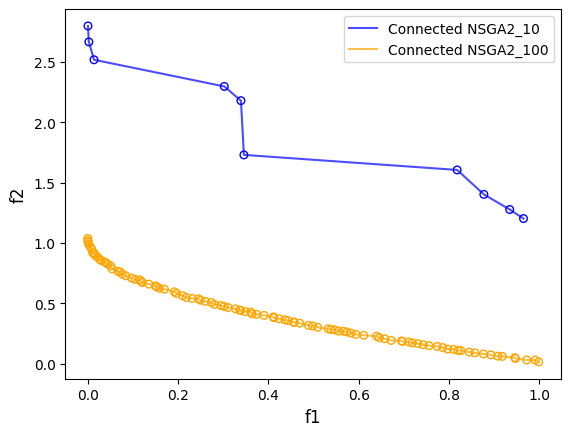

In [ ]:
problem = get_problem("zdt1", n_var=30)
algorithm = NSGA2(pop_size=100)
ref_point = [20000, 50000]

# NUESTRO ALGORITMO
best_solution, metrics_summary, ref_point = multiple_experiments_with_metrics(problem, algorithm, n_gens=10, ref_point=ref_point, num_experiments=10)
# ALGORITMO NSGA2 A BATIR
res_obj = minimize(problem, algorithm, ('n_gen', 100), verbose=False) # Algoritmo de optimización a batir

hv, spr, spa = calculate_metrics(best_solution, ref_point)
hv_obj, spr_obj, spa_obj = calculate_metrics(res_obj.F, ref_point)

data = {'Hipervolumen': [hv, hv_obj], 'Dispersión (SPR)': [spr, spr_obj], 'Espaciado (SPA)': [spa, spa_obj]}

df = pd.DataFrame(data, index=['Mejor Solución', 'NSGA2 a Batir'])
print(f"\n {df}")

#########################################################
######################## Gráfica ########################
#########################################################

sorted_res = best_solution[np.argsort(best_solution[:, 0])]
sorted_res2 = res_obj.F[np.argsort(res_obj.F[:, 0])]

# líneas que conectan los puntos de NSGA2_10 y NSGA2_100
plt.plot(sorted_res[:, 0], sorted_res[:, 1], color="blue", alpha=0.7, label="Connected NSGA2_10")
plt.plot(sorted_res2[:, 0], sorted_res2[:, 1], color="orange", alpha=0.7, label="Connected NSGA2_100")

plt.scatter(best_solution[:, 0], best_solution[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(res_obj.F[:, 0], res_obj.F[:, 1], s=30, facecolors='none', edgecolors='orange')

# Rellena los puntos scatter con color
# plt.scatter(best_solution[:, 0], best_solution[:, 1], s=30, c='blue', edgecolors='blue')
# plt.scatter(res_obj.F[:, 0], res_obj.F[:, 1], s=30, c='orange', edgecolors='orange')

plt.xlabel('f1', fontsize=12)
plt.ylabel('f2', fontsize=12)
plt.legend()

plt.show()